In [35]:
# !pip install langchain_community
# !pip install boto3 -U

In [36]:
import pandas as pd
import numpy as np
import boto3
import json
from botocore.config import Config
from langchain_community.chat_models import BedrockChat
from langchain_core.prompts import PromptTemplate
from langchain.schema import HumanMessage
import math
from scipy.stats import ks_2samp
from tqdm import tqdm
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt

In [37]:
def generate_schema(df):
    schema = {}

    # For numeric columns
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    for col in numeric_columns:
        col_stats = {
            "data_type": "numeric",
            "mean": df[col].mean(),
            "std": df[col].std(),
            "min": df[col].min(),
            "max": df[col].max(),
            "25th_percentile": df[col].quantile(0.25),
            "50th_percentile": df[col].quantile(0.50),  # Median
            "75th_percentile": df[col].quantile(0.75)
        }
        schema[col] = col_stats

    # For categorical columns
    categorical_columns = df.select_dtypes(include=['object', 'category']).columns
    for col in categorical_columns:
        if df[col].nunique() < 50:  # Treat columns with a small number of unique values as categorical
            value_counts = df[col].value_counts(normalize=True)
            col_stats = {
                "data_type": "categorical",
                "distribution": value_counts.to_dict()
            }
            schema[col] = col_stats

    # For free-form text columns (treated as 'object' but with high uniqueness)
    text_columns = df.select_dtypes(include=['object']).columns
    for col in text_columns:
        if df[col].nunique() > 50:  # Assume high uniqueness indicates free-form text
            text_lengths = df[col].dropna().apply(len)  # Calculate the length of each text entry
            col_stats = {
                "data_type": "text",
                "average_length": text_lengths.mean(),
                "min_length": text_lengths.min(),
                "max_length": text_lengths.max(),
                "sample_text": df[col].dropna().sample(3).tolist()  # Provide a few examples
            }
            schema[col] = col_stats

    return schema

In [38]:
# Load the model
def load_model(top_k, top_p, temperature):
    config = Config(read_timeout=1000)
    bedrock_runtime = boto3.client(service_name='bedrock-runtime', 
                          region_name='us-east-1',
                          config=config)

    model_id = "anthropic.claude-3-5-sonnet-20240620-v1:0"
    
    model_kwargs = { 
        "max_tokens": 200000,
        "temperature": temperature,
        "top_k": top_k,
        "top_p": top_p,
        "stop_sequences": ["\n\nHuman"]
    }
    
    model = BedrockChat(
        client=bedrock_runtime,
        model_id=model_id,
        model_kwargs=model_kwargs,
    )

    return model

In [39]:
def format_examples(df):
    non_numeric_columns = df.select_dtypes(exclude=[np.number]).columns
    examples_str = ""
    for index, row in df[non_numeric_columns].iterrows():
        row_string = ", ".join([f"{non_numeric_columns[i]}: {row[i]}" for i in range(len(non_numeric_columns))])
        examples_str += row_string + "\n"
    return examples_str

In [40]:
def format_rows(row):
    return  ", ".join([f"{col}: {row[col]}" for col in row.index if pd.notna(row[col])])

In [41]:
def row_len(text):
    return len(text)

In [42]:
def max_examples(csv_data, max_context_tokens, prompt_tokens, response_token_buffer=0.20):
    non_numeric_col = csv_data.select_dtypes(exclude=[np.number])
    formatted_exmaples = non_numeric_col.apply(format_rows, axis =1)
    char_per_row = int(formatted_exmaples.apply(row_len).mean())
    max_available = int((max_context_tokens*(1-response_token_buffer)) / char_per_row)
    max_examples_percent = int(0.6 * len(csv_data))
    return (min(max_available, max_examples_percent),char_per_row)

In [43]:
def select_strat_col(csv_data, num_cols=2):
    cat_cols = csv_data.select_dtypes(include=['object', 'category']).columns
    score = {}
    for col in cat_cols:
        value_counts = csv_data[col].value_counts(normalize=True)
        max_prop = value_counts.max()
        score[col] = max_prop
    sort = sorted(score, key=score.get)
    return sort[:num_cols]

In [44]:
def generate_examples(csv_data, num_examples):
    select_col = select_strat_col(csv_data, num_cols=2)
    if select_col:
        sample = csv_data.groupby(select_col, group_keys=False).apply(
            lambda x: x.sample(frac=min(1.0, num_examples / len(csv_data)))
        )
    else:
        sample = csv_data.sample(num_examples)
    return sample

In [45]:
def create_prompt_template_without_numeric():
    template = """
    You are a helpful AI assistant for creating new datasets. 
    Your task is to generate new observations based on the provided examples and schema.
    The new observations should be similar to the examples.

    **Categorical Data**: 
    - For each categorical column, ensure that the frequency distribution of the generated data matches the distribution provided in the schema.
    - The proportion of each category (e.g., Male/Female) should be preserved based on the frequencies in the schema.
    - Do no include any null values. Alway use a value from one of the categories.

    **Free-Form Text**:
    - For free-form text columns, generate text that is similar in style and structure to the examples provided.
    - Ensure that the generated text has a length that falls within the range indicated in the schema.
    - The average length of the generated text should be close to the average length provided in the schema.

    The formatting of the new observations should match the formatting of the examples: 
    column 1: value 1, column 2: value 2...column n: value n.

    **Examples**:
    {examples}

    **Schema**:
    {schema}
    
    **Count**: Generate {count} new observations.

    Only return the new observations, do not include any explanation.
    """
    
    prompt = PromptTemplate(
        template=template,
        input_variables=["examples", "schema", "count"]
    )

    return prompt

In [46]:
def generate_response_for_categorical_and_text(csv_data, num_examples, schema, row_tokens):
    examples = generate_examples(csv_data, num_examples)
    prompt_examples = format_examples(examples)  # Use only non-numeric examples
    
    prompt_template = create_prompt_template_without_numeric()
    filled_prompt = prompt_template.format(
        examples=prompt_examples,
        schema=schema,
        count=math.ceil((5000 / row_tokens))
    )
    
    message = HumanMessage(content=filled_prompt)
    response = llm([message])
    
    return response.content

In [47]:
def generate_numeric(original_df, num_rows):
    numeric_columns = original_df.select_dtypes(include=[np.number]).columns
    generated_numeric_data = pd.DataFrame()

    for col in numeric_columns:
        # Resample from the original column's values
        generated_numeric_data[col] = np.random.choice(original_df[col], size=num_rows, replace=True)
    
    return generated_numeric_data

In [48]:
def create_new_dataframe(text):
    obs = text.split('\n')
    data_dicts = []
    for line in obs:
        pairs = line.split(', ')
        entry_dict = {}
        for pair in pairs:
            if ': ' in pair:
                k, v = pair.split(': ', 1)  
                entry_dict[k.strip()] = v.strip()
        data_dicts.append(entry_dict)
    return pd.DataFrame(data_dicts)


In [49]:
def generate_combined_data(csv_data, num_examples, schema, row_tokens):
    # Generate numeric
    numeric_data = generate_numeric(csv_data, num_examples)

    # Generate categorical and text 
    response_text = generate_response_for_categorical_and_text(csv_data, num_examples, schema, row_tokens)
    categorical_and_text_data = create_new_dataframe(response_text)

    # Combine numeric and categorical/text data
    combined_data = pd.concat([numeric_data.reset_index(drop=True), categorical_and_text_data.reset_index(drop=True)], axis=1)

    # Ensure the combined data has the same column order as the original dataset
    combined_data = combined_data[csv_data.columns]

    return combined_data

In [50]:
def gen_all_obs(gen_cycles, csv_data, num_examples, schema, row_tokens):
    df_list = []
    for i in tqdm(range(gen_cycles), desc="Generating Observations"):
        temp = generate_combined_data(csv_data, num_examples, schema, row_tokens)
        df_list.append(temp)
    final_df = pd.concat(df_list, ignore_index=True)
    return final_df

In [51]:
def fill_missing_cat(new_data,schema,col):
    distribution = schema[col]['distribution']
    cat = list(distribution.keys())
    probs =  list(distribution.values())
    
    missing_idx = new_data[new_data[col].isnull()].index
    
    sample_cat = np.random.choice(cat,size=len(missing_idx), p = probs)
    
    new_data.loc[missing_idx,col] = sample_cat
    
    return new_data
    

In [52]:
## run ##

In [53]:
# Load the file
file_path = "housing.csv"
csv_data = pd.read_csv(file_path)

In [54]:
# Define model parameters
top_k = 50
top_p = 0.9
temperature = 0
llm = load_model(top_k, top_p, temperature)

In [55]:
# Generate schema from the dataset
schema = generate_schema(csv_data)

In [56]:
# Define the number of tokens
max_context_tokens = 200000  # Example context window size
prompt_tokens = 2000  # Estimate for tokens used by the prompt
response_token_buffer = 0.2

In [57]:
# Get the number of examples and tokens per row
num_examples, row_tokens = max_examples(csv_data, max_context_tokens, prompt_tokens, response_token_buffer)

In [58]:
# Define the number of observations and cycles
num_obs = 20000
gen_cycles = math.ceil(num_obs / (20000 / row_tokens))

In [59]:
# Generate observations with combined data generation (numeric resampling + LLM for categorical/text)
obs_df = gen_all_obs(gen_cycles, csv_data, num_examples, schema, row_tokens)

Generating Observations: 100%|██████████| 25/25 [10:31<00:00, 25.27s/it]


In [60]:
gen_df = obs_df[:num_obs]

In [61]:
types = dict(csv_data.dtypes)
for column, dtype in types.items(): 
    try:
        gen_df[column] = gen_df[column].astype(dtype)
    except ValueError as e:

        print(f"Error converting {column} to {dtype}")

/tmp/ipykernel_8011/2446309084.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gen_df[column] = gen_df[column].astype(dtype)


In [62]:
cat_cols = csv_data.select_dtypes(exclude=[np.number]).columns
for col in cat_cols:
    final_df = fill_missing_cat(gen_df,schema,col)

In [63]:
final_df.to_csv('housing_new_20k.csv')

In [73]:
o_frq = csv_data['ocean_proximity'].value_counts(normalize=True)
g_frq = final_df['ocean_proximity'].value_counts(normalize=True)

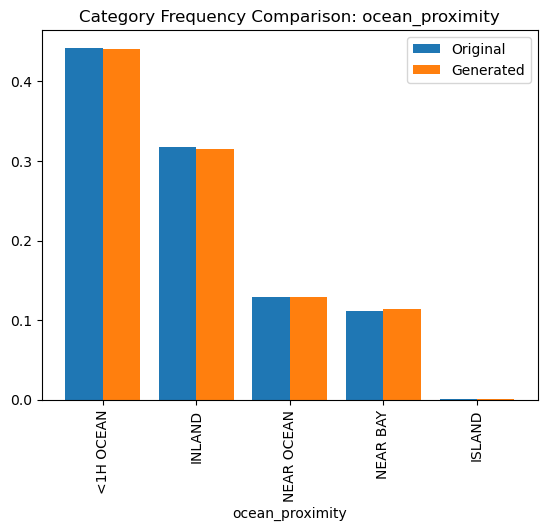

<Figure size 640x480 with 0 Axes>

In [79]:
f_df = pd.DataFrame({"Original": o_frq,"Generated": g_frq}).fillna(0)
f_df.plot(kind="bar", width=0.8)
plt.title(f'Category Frequency Comparison: ocean_proximity')
plt.show()
plt.savefig("Frequency.png") 

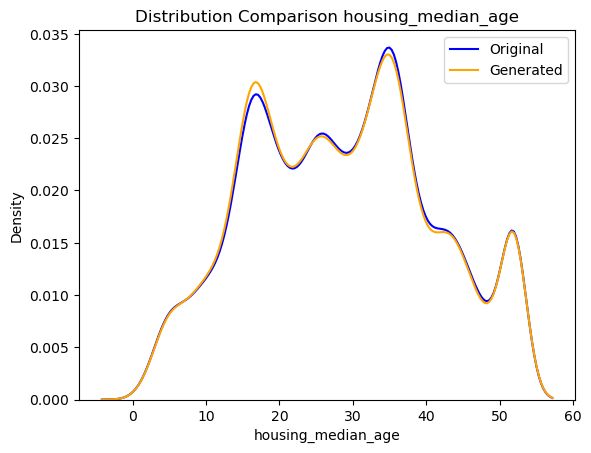

In [77]:
import seaborn as sns
sns.kdeplot(data=csv_data, x="housing_median_age", label='Original', color='blue')
sns.kdeplot(data=final_df, x="housing_median_age", label='Generated',color = 'orange')
plt.title(f'Distribution Comparison housing_median_age')
plt.legend()
plt.show
plt.savefig("Distribution.png") 

In [65]:
def distribution_check_summary(original_data,new_data, p_value_threshold=0.05):
    results = []
    num_cols = original_data.select_dtypes(include=[np.number]).columns
    cat_cols = original_data.select_dtypes(exclude=[np.number]).columns
    
    for col in num_cols: 
        ks_stat, p_value = ks_2samp(original_data[col], new_data[col])
        result = "Pass" if p_value > p_value_threshold else "Fail"
        
        results.append({'Column': col,
                        'Type': 'Numeric',
                        'P-Value': p_value,
                        'Test': 'KS Test',
                        'Result': result
                       }
            )
        
    for col in cat_cols: 
        original_count = original_data[col].value_counts()
        new_count = new_data[col].value_counts()
        
        counts = pd.DataFrame({'original': original_count, 'generated': new_count}).fillna(0)
        chi2_stat, p_value, dof, ex = chi2_contingency(counts.T)
        result = "Pass" if p_value > p_value_threshold else "Fail"
        
        results.append({'Column': col,
                        'Type': 'Categorical',
                        'P-Value': p_value,
                        'Test': 'Chai-Square Test',
                        'Result': result
                       }
            ) 
    result_df = pd.DataFrame(results)
    return result_df

In [66]:
distribution_check_summary(csv_data,final_df)

,Column,Type,P-Value,Test,Result
0,longitude,Numeric,0.896828,KS Test,Pass
1,latitude,Numeric,0.750496,KS Test,Pass
2,housing_median_age,Numeric,0.360406,KS Test,Pass
3,total_rooms,Numeric,0.214770,KS Test,Pass
4,total_bedrooms,Numeric,0.857162,KS Test,Pass
5,population,Numeric,0.773815,KS Test,Pass
6,households,Numeric,0.981859,KS Test,Pass
7,median_income,Numeric,0.841832,KS Test,Pass
8,median_house_value,Numeric,0.928085,KS Test,Pass
9,ocean_proximity,Categorical,0.901980,Chai-Square Test,Pass
